# Filtering

In [1]:
import numpy as np
import cv2 as cv
from scipy.signal import convolve2d
from scipy.ndimage import median_filter
import random
import copy
import matplotlib.pyplot as plt
import sys
from cv2.ximgproc import anisotropicDiffusion

Function to display images.

In [2]:

def display_imgs(imgs, titles):

    for ind, img in enumerate(imgs):
        print(img.shape)
        if len(img.shape) > 2:
            b,g,r = cv.split(img)
            img = cv.merge((r,g,b))
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')
        plt.title(titles[ind])
        plt.show()


Read image file

(168, 300, 3)


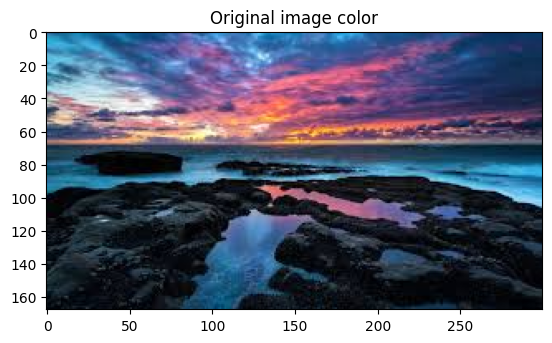

(168, 300)


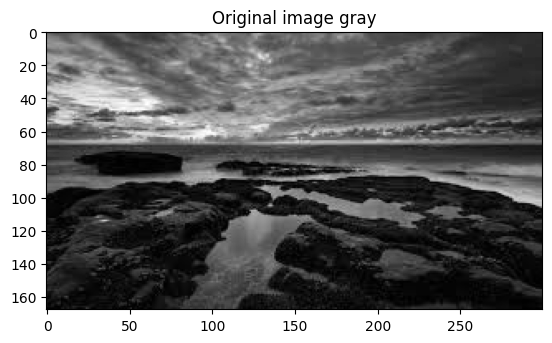

In [3]:
img_color_int = cv.imread('beach.jpeg')

img_gray_int = cv.cvtColor(img_color_int, cv.COLOR_BGR2GRAY)
img_gray_float = np.float32(img_gray_int / 255)

img_color_float = np.float32(img_color_int / 255)
x, y, z = img_color_float.shape

display_imgs([img_color_float, img_gray_int], 
             ['Original image color', 'Original image gray'])

## Section 1 Gaussian Noise

Add Gaussian noise

(168, 300, 3)


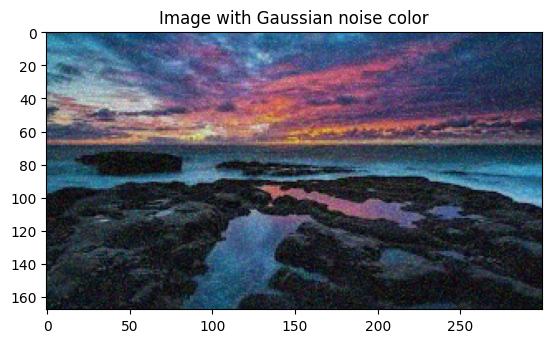

(168, 300)


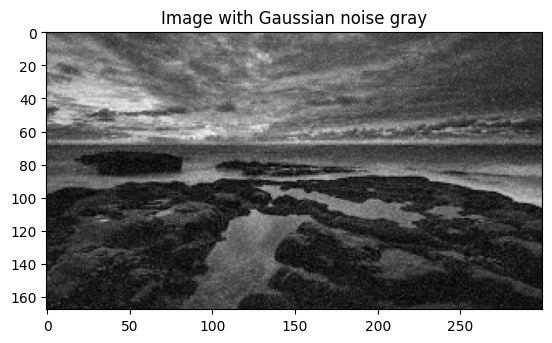

In [4]:

mean = 0
var = 0.01
sd = np.sqrt(var)

noise = np.random.normal(loc=mean, scale=sd, size=(x, y, z))
# absolute so negative values become positive since images don't have negative values 
# for pixels.
noise = np.abs(noise)

img_wnoise_color_float = noise + img_color_float

img_wnoise_color_int = cv.normalize(img_wnoise_color_float, None, alpha = 0, 
                                    beta = 255, norm_type = cv.NORM_MINMAX, 
                                    dtype = cv.CV_32F)

img_wnoise_color_int = np.uint8(img_wnoise_color_int)
img_wnoise_gray_int = cv.cvtColor(img_wnoise_color_int, cv.COLOR_BGR2GRAY)

display_imgs([img_wnoise_color_int, img_wnoise_gray_int], 
             ['Image with Gaussian noise color', 'Image with Gaussian noise gray'])

Apply mean filter

(168, 300, 3)


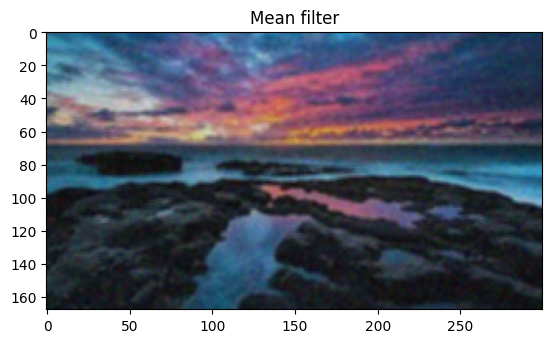

In [5]:

img_wnoise_color_float = np.float32(img_wnoise_color_int / 255)
mean_kernel3 = np.full((3, 3), 1/9, dtype=np.float32)

mean_filtered = cv.filter2D(img_wnoise_color_float, -1, mean_kernel3)

display_imgs([mean_filtered], ['Mean filter'])

Apply median filter

(168, 300)


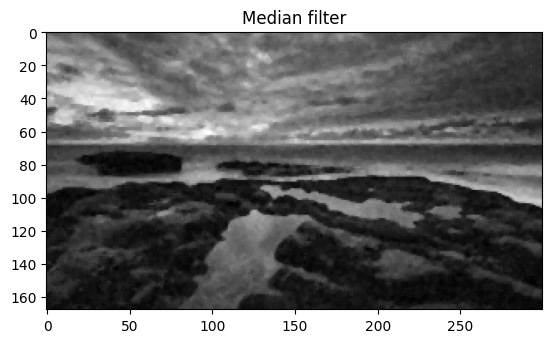

In [6]:

median_filtered = median_filter(img_wnoise_gray_int, size=(3, 3))
display_imgs([median_filtered], ['Median filter'])

Apply anisotropic filter

(168, 300, 3)


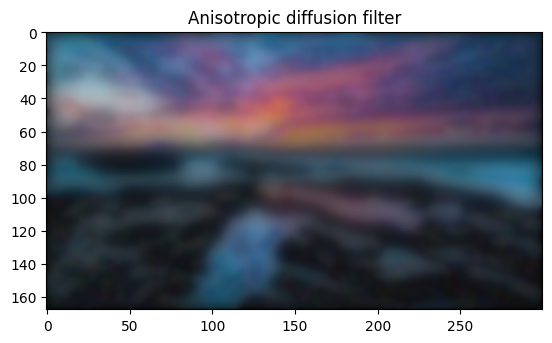

In [7]:


anis_filtered = anisotropicDiffusion(img_wnoise_color_int, 0.075 ,80, 100)
display_imgs([anis_filtered], ['Anisotropic diffusion filter'])



## Section 2 Salt and Pepper

Add salt and pepper noise

(168, 300, 3)


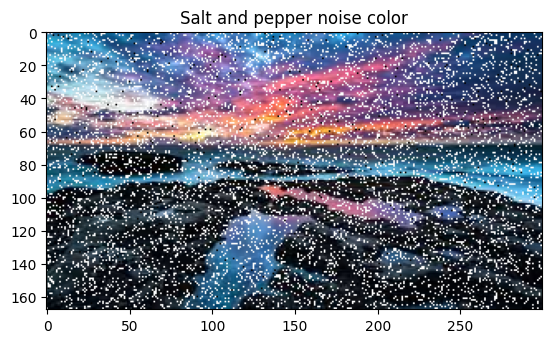

(168, 300)


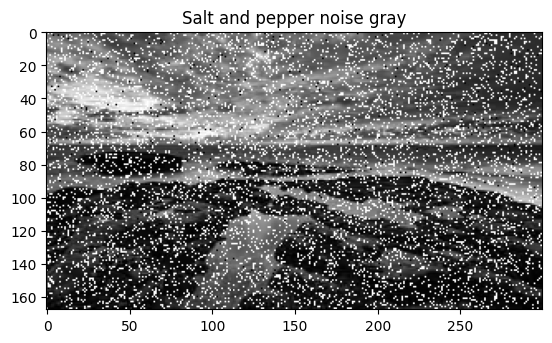

In [8]:

def add_spnoise(img): 
    """ Randomly pick some pixels in the 
    image for coloring them white and some for black"""
    
    row , col, _ = img.shape 
    img_c = copy.copy(img)
    
    number_of_pixels = random.randint(300, 10000) 
    for i in range(number_of_pixels): 
        y_coord=random.randint(0, row - 1) 
        x_coord=random.randint(0, col - 1) 
        img_c[y_coord][x_coord] = 1
          
    number_of_pixels = random.randint(300 , 10000) 
    for i in range(number_of_pixels): 
        y_coord=random.randint(0, row - 1) 
        x_coord=random.randint(0, col - 1) 
        img_c[y_coord][x_coord] = 0
          
    return img_c

sp_img_color_float = add_spnoise(img_color_float)
sp_img_color_int = cv.normalize(sp_img_color_float, None, alpha = 0, beta = 255, 
                                norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
sp_img_color_int = np.uint8(sp_img_color_int)

sp_img_gray_float = cv.cvtColor(sp_img_color_float, cv.COLOR_BGR2GRAY)

display_imgs([sp_img_color_float, sp_img_gray_float], 
             ['Salt and pepper noise color', 'Salt and pepper noise gray'])


Apply mean filter

(168, 300, 3)


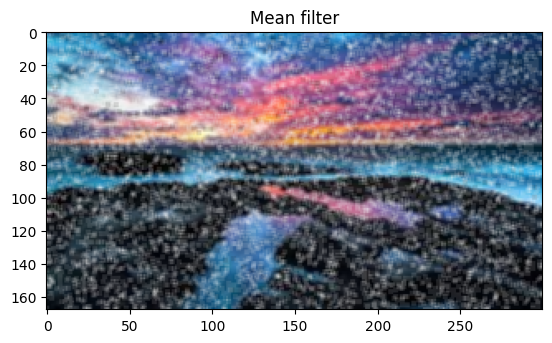

In [9]:
mean_kernel3 = np.full((3, 3), 1/9)
mean_filtered = cv.filter2D(sp_img_color_float, -1, mean_kernel3)
display_imgs([mean_filtered], ['Mean filter'])

Apply median filter

(168, 300, 3)


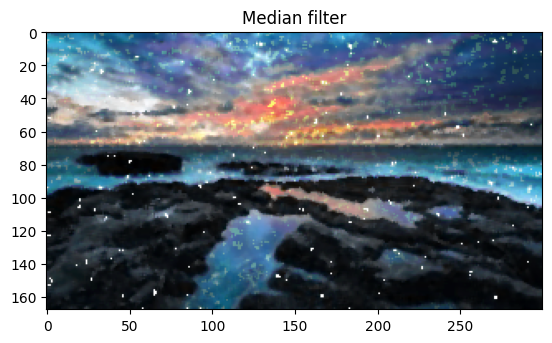

In [10]:
median_filtered = median_filter(sp_img_color_float, size=(3, 3, 3))
display_imgs([median_filtered], ['Median filter'])

Apply anisotropic filter

(168, 300, 3)


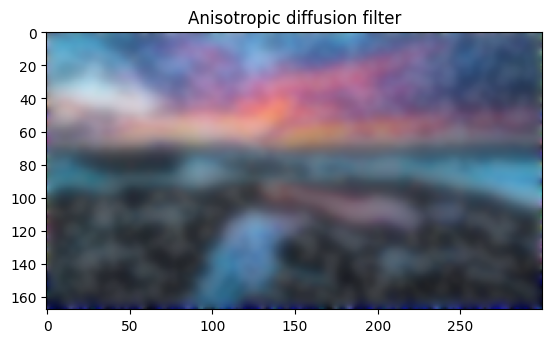

In [11]:

anis_filtered = anisotropicDiffusion(sp_img_color_int, 0.075 ,80, 100)
display_imgs([anis_filtered], ['Anisotropic diffusion filter'])


## Section 3 Multiple Filters

In [12]:
ddepth = cv.CV_32F
kernel_size = 3

Laplacian

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(168, 300, 3)


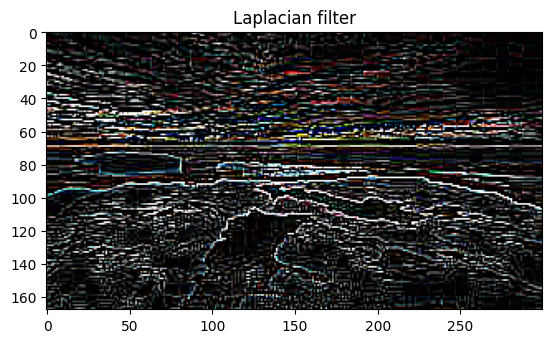

In [13]:
dst = cv.Laplacian(img_color_float, ddepth, ksize=kernel_size)
display_imgs([dst], ['Laplacian filter'])

Sobel x

(168, 300)


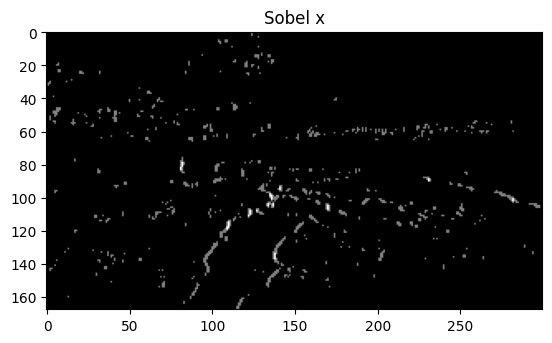

In [14]:
scale = 1
delta = 0

src = np.float32(img_gray_float)
grad_x = cv.Sobel(src, ddepth, 1, 0, ksize=3, 
                  scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

abs_grad_x = cv.convertScaleAbs(grad_x)


display_imgs([abs_grad_x], ['Sobel x'])


Laplacian of Gaussian

(168, 300)


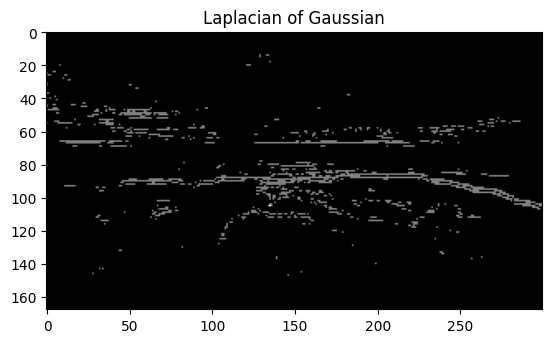

In [15]:


src = img_gray_float

# [reduce_noise]
# Remove noise by blurring with a Gaussian filter
src = cv.GaussianBlur(src, (3, 3), 0)
src = np.float32(src)

# [laplacian]
# Apply Laplace function
dst = cv.Laplacian(src, ddepth, ksize=kernel_size)

abs_dst = cv.convertScaleAbs(dst)

display_imgs([abs_dst], ['Laplacian of Gaussian'])


Sharpening

(168, 300)


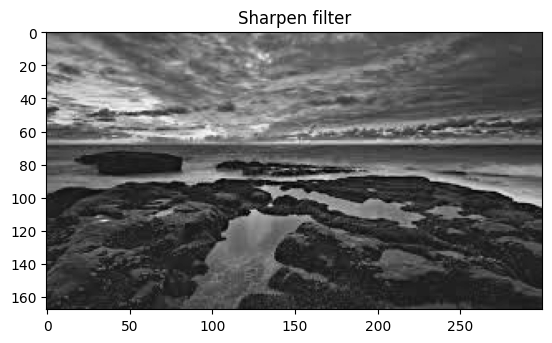

In [16]:
# Gaussian smoothing filter and subtract the smoothed version from the original image

gblur = cv.GaussianBlur(img_gray_float, (0, 0), 3)
sharpenned = cv.addWeighted(img_gray_float, 1.5, gblur, -0.5, 0)
display_imgs([sharpenned], ['Sharpen filter'])


## Section 4 Homomorphic Filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(168, 300, 3)


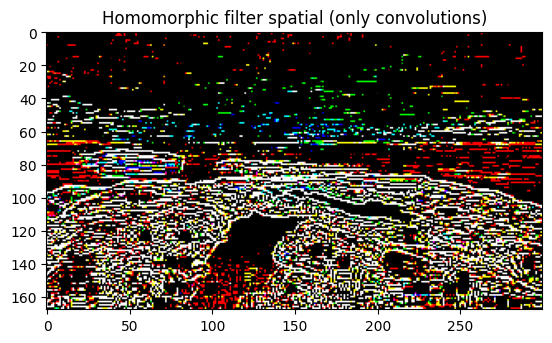

In [17]:

# Perform the logarithmic operation
Ilog = np.log(img_color_float * 1000 + 10 * np.ones_like(img_color_float))

# Define the sharpening filter
sharp = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]) / 0.5

# Apply convolution
Isharp = cv.filter2D(Ilog, -1, sharp)
#display_imgs([Isharp], ['Ishaeo'])

# Perform the exponential operation
Isharp = np.exp(Isharp) - 10 * np.ones_like(Isharp)

#print(Isharp)
display_imgs([Isharp], ['Homomorphic filter spatial (only convolutions)'])

(168, 300)


/var/folders/3s/s_cfgxk120b8xn2g6y1m9psw0000gn/T/ipykernel_97344/3510460652.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  H[i, j] = 1 / (1 + (d / A[i, j])**(2 * n))


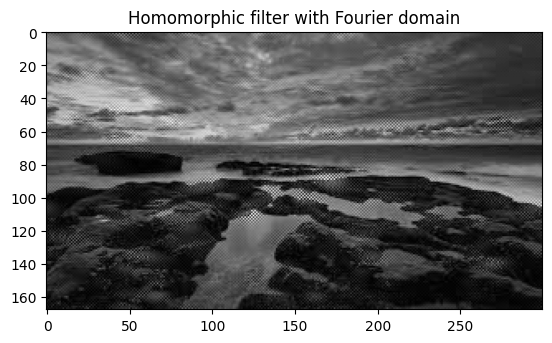

In [18]:
def homofil(im, d, r, c, n):
    # Butterworth high pass filter
    A = np.zeros((r, c))
    H = np.zeros((r, c))

    for i in range(r):
        for j in range(c):
            A[i, j] = np.sqrt((i - r/2)**2 + (j - c/2)**2)
            H[i, j] = 1 / (1 + (d / A[i, j])**(2 * n))

    # Homomorphic filtering, adjusting alphaL and alphaH values accordingly
    alphaL = 0.0999
    alphaH = 1.01
    H = (alphaH - alphaL) * H + alphaL
    H = 1 - H

    # Log of image
    im_l = np.log2(1 + im)

    # DFT of logged image
    im_f = np.fft.fft2(im_l)

    # Apply filter to DFT image
    im_nf = H * im_f

    # Inverse DFT of filtered image
    im_n = np.abs(np.fft.ifft2(im_nf))

    # Inverse log
    im_e = np.exp(im_n)

    display_imgs([im_e], ['Homomorphic filter with Fourier domain'])


homofil(img_gray_float, d=10, r=x, c=y, n=2)

## Section 5 Implement Own Versions of FIR IIR

alpha=0.5 IIR

weights for FIR -> 0.4 * v4, 0.3 * v3, 0.2 * v2, 0.1 * v1, 0.0 * gray

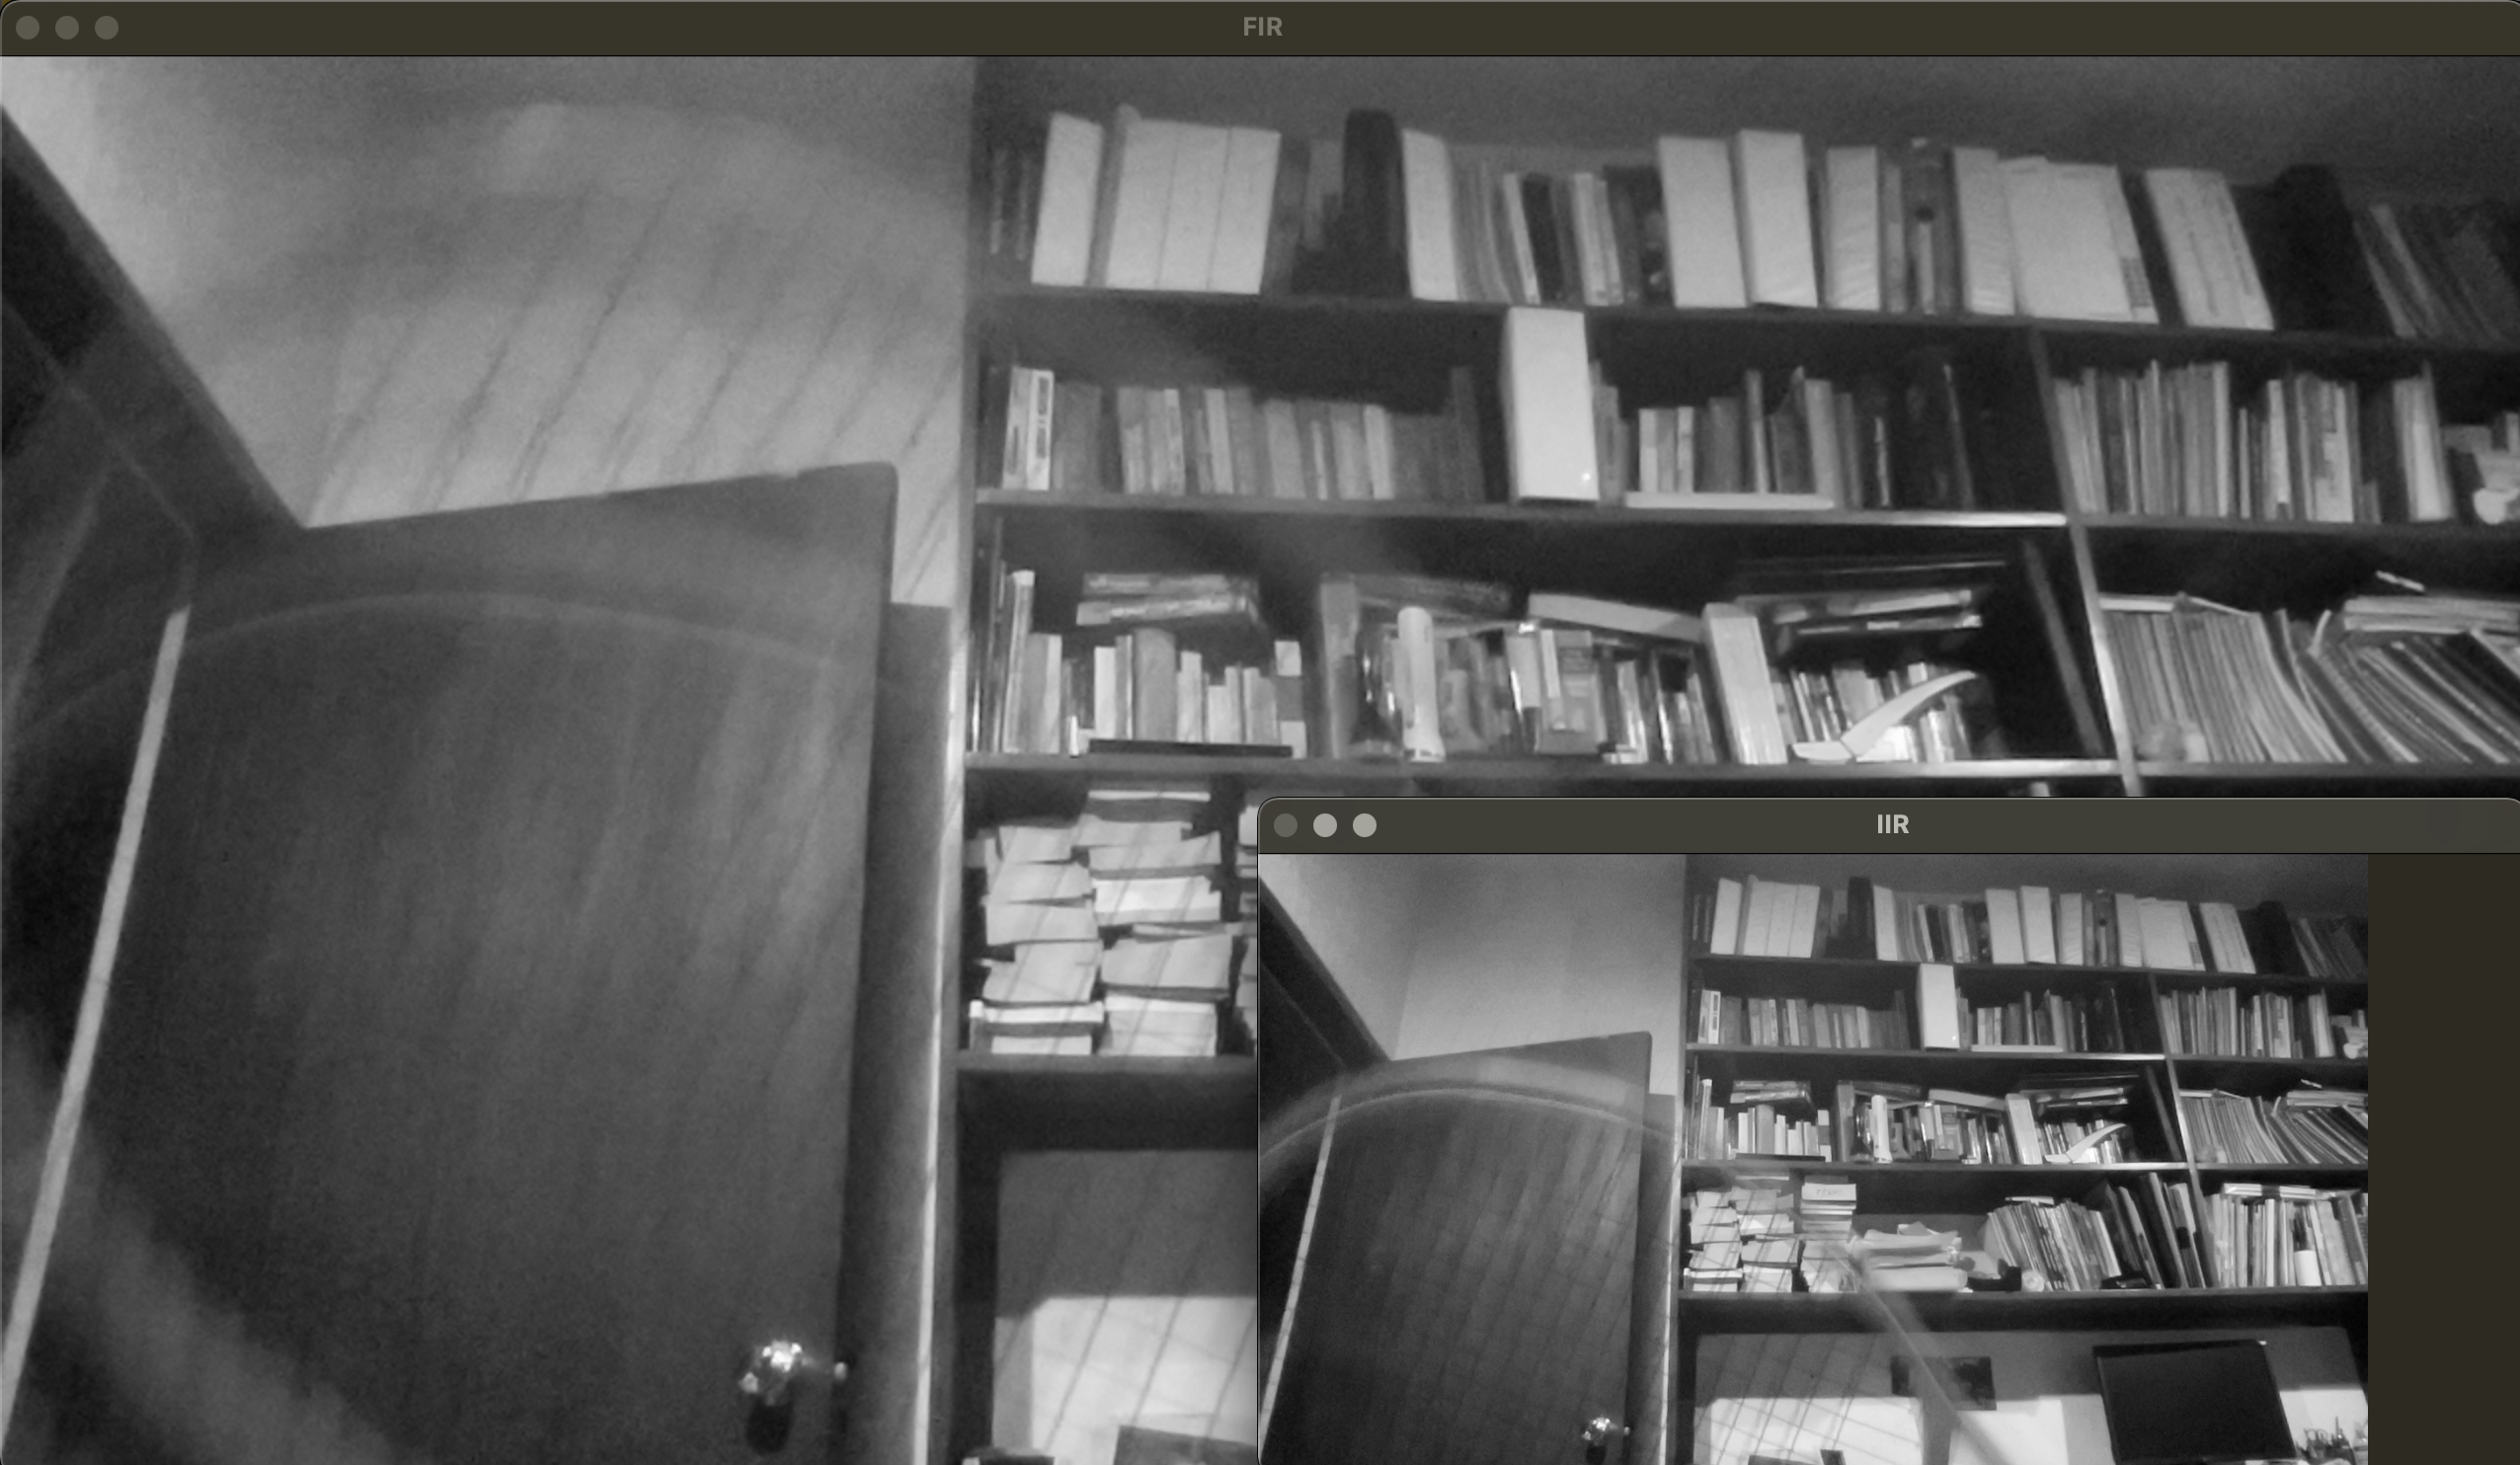

the code for IIR and FIR (better to execute in isolated python file)

In [ ]:
import cv2 as cv


cap = cv.VideoCapture(0)

x = 0

if not cap.isOpened():
    print("Cannot open camera")
    exit()

ret, frame = cap.read()
    # if frame is read correctly ret is True
if not ret:
    print("Can't receive frame (stream end?). Exiting ...")

gray2 = frame[:,:,0]
gray2.astype(float)
frame_v4 = gray2
frame_v3 = gray2
frame_v2 = gray2
frame_v1 = gray2

while True:
    x=x+1;
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    cv.imshow('Color', frame)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray.astype(float)
    grayN = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    # Display the resulting frame
    cv.imshow('Gray', grayN)

    alpha=0.5
    gray2 = gray*alpha + gray2*(1.0-alpha)
    
    FIRimg = (frame_v4*0.4 + frame_v3*0.3 + frame_v2*0.2 +frame_v1*0.1 + gray*0.0);
    img = cv.normalize(FIRimg, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    frame_v4 = frame_v3
    frame_v3 = frame_v2
    frame_v2 = frame_v1
    frame_v1 = gray
    # Display the resulting frame
    cv.imshow('FIR',img)


    img = cv.normalize(gray2, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    cv.imshow('IIR', img)
    if cv.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()